In [1]:
import pandas as pd
import os
from tqdm.auto import tqdm
import argparse # 1
import glob # 2
import xml.etree.ElementTree as ET # 3
import cv2
import ast # 4
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as immg
import random
import torch
import torchvision
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
!mkdir "data" "data/images" "data/labels"

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/images’: File exists
mkdir: cannot create directory ‘data/labels’: File exists


In [4]:
df = pd.read_csv("./data/labels/train_solution_bounding_boxes (1).csv")

In [5]:
# dataset = {
#     "xmin": [],
#     "ymin": [],
#     "xmax": [],
#     "ymax": [],
#     "class": [],
#     "file": [],

# }


In [6]:
# all_files =  []

# for file in os.walk("./data/images/"):
#   all_files.append(file)


In [7]:
# all_files = all_files[0][2]

In [8]:
# for file in all_files:
#   try:
#     with open(f"./data/labels/{file.split('.')[0]}.txt", "r") as f:

#       coor = f.readline()
#       coor = coor.split(" ")
#       dataset["class"].append(coor[0])
#       dataset["xmin"].append(coor[1])
#       dataset["ymin"].append(coor[2])
#       dataset["xmax"].append(coor[3])
#       dataset["ymax"].append(coor[4])
#       dataset["file"].append(file.split(".")[0])

#   except FileNotFoundError:
#     all_files.remove(file)




In [9]:
# cols = [i for i in dataset.keys()]

In [10]:
# df = pd.DataFrame(dataset, columns=cols)
# df.head()

In [11]:
# df["ymax"] = [i[:-2] for i in df["ymax"]]
# df = df.drop("file", axis=1).astype("float32")

In [12]:
# df["width"] = [df["xmax"][i] - df["xmin"][i] for i in range(len(df))]
# df["height"] = [df["ymax"][i] - df["ymin"][i] for i in range(len(df))]

In [13]:
# class_names = ["scratch", "dirty", "stain", "damage"]
# df["class_names"] = df["class"].map(lambda x: class_names[int(x)])

In [14]:
# df.head()

In [15]:
# df.isnull().sum()

In [16]:
# df.iloc[0]["xmin"]

In [17]:
df.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [18]:
df["class"] = [0 for i in range(len(df))]
df["class_names"] = ["car" for i in range(len(df))]

In [19]:
import matplotlib
def plot_image(image_name):
  print(image_name)
  img = plt.imread(f"./data/images/{image_name}.jpg")
  fig, ax = plt.subplots(nrows=1, ncols=1 ,figsize=(10, 7), dpi=200)
  ax.imshow(img)
  box = df[df["image"] == f"{image_name}.jpg"]
  x, y, w, h = box["xmin"].values, box["ymin"].values, box["xmax"].values - box["xmin"].values, box["ymax"].values - box["ymin"].values
  print(x, y, w, h)
  rect = matplotlib.patches.Rectangle((x, y), w, h, linewidth=1, edgecolor="r", facecolor="none")
  ax.add_patch(rect)
  ax.plot()


vid_4_1000
[281.2590449] [187.0350708] [46.4688856] [36.1904762]


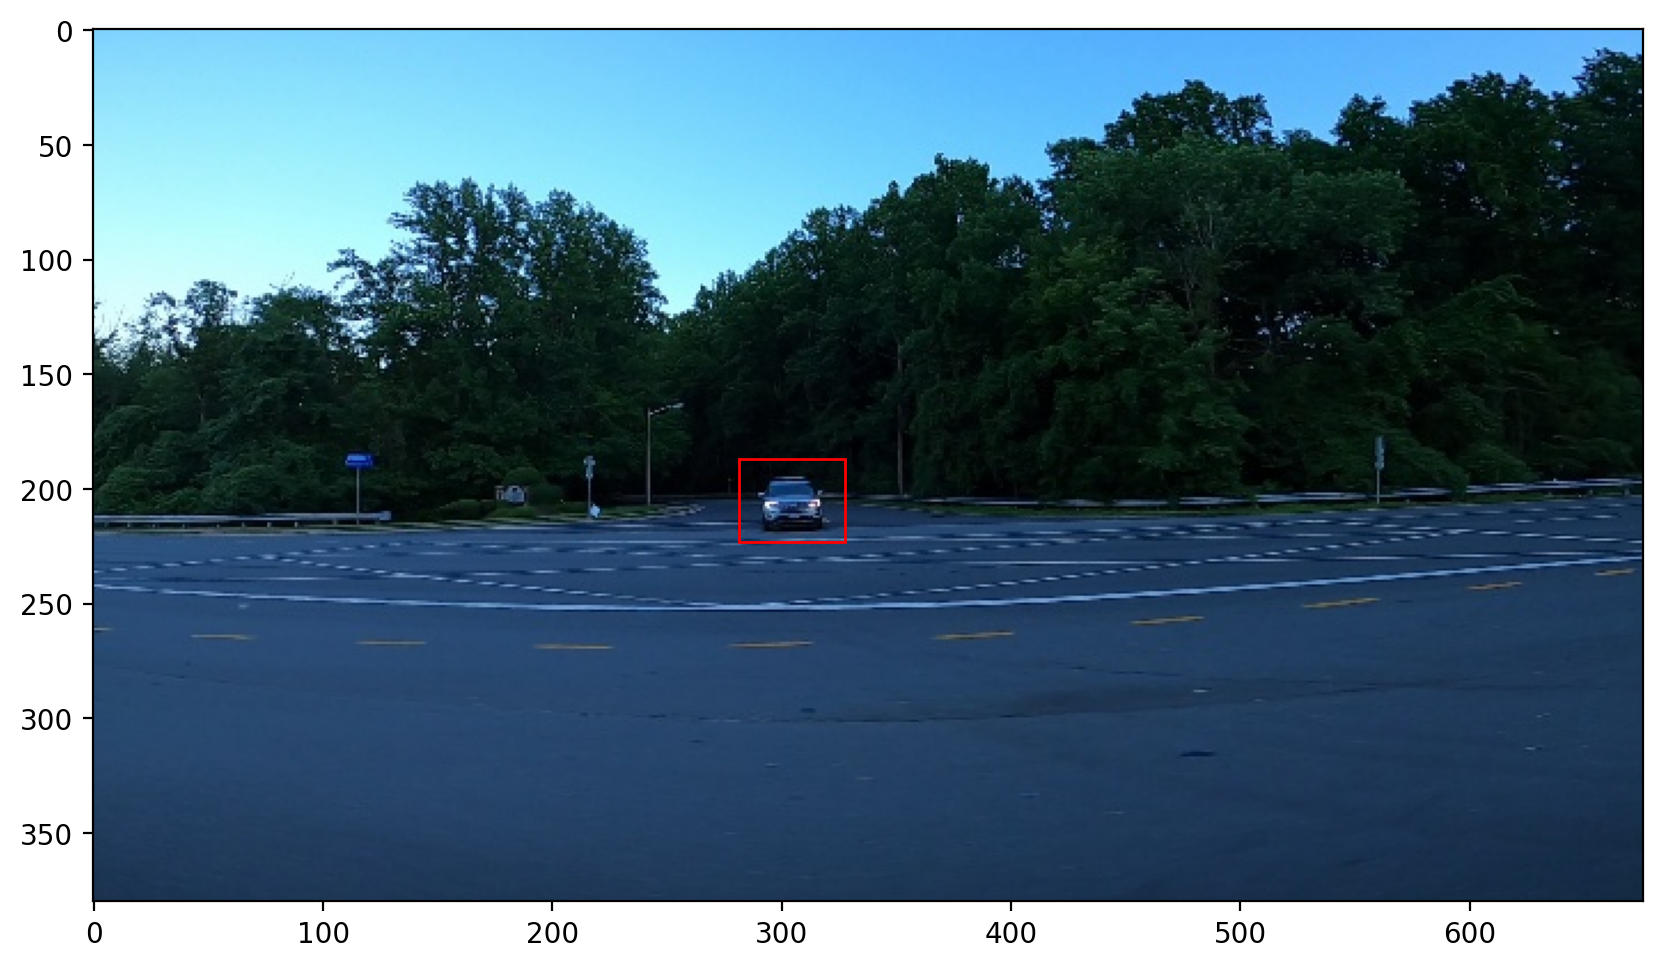

In [20]:
plot_image("vid_4_1000")

In [21]:
class Data(object):
  def __init__(self, df, IMG_DIR, transforms):
    self.df = df
    self.image_ids = self.df["image"].unique().tolist()
    self.transforms = transforms
    self.img_dir =  IMG_DIR

  def __len__(self):
    return len(self.image_ids)

  def __getitem__(self, idx):
    image_id = self.image_ids[idx]
    image_values = self.df[self.df['image'] == image_id]
    image = cv2.imread(self.img_dir+image_id,cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    boxes = image_values[["xmin", "ymin", "xmax", "ymax"]].to_numpy()
    area = (boxes[:,3] - boxes[:, 1] * (boxes[:, 2] - boxes[:, 0]))
    labels = image_values["class"].values
    labels = torch.tensor(labels)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = torch.tensor([idx])
    target["area"] = torch.as_tensor(area, dtype=torch.float32)
    target["iscrowd"] = torch.zeros(1, dtype=torch.int64)

    if self.transforms:
      sample = {
          "image": image,
          "bboxes": target["boxes"],
          "labels": labels
      }

      samlple = self.transforms(**sample)
      image = sample["image"]
      target["boxes"] = torch.stack(tuple(map(torch.tensor, zip(*sample["bboxes"])))).permute(1, 0)
    return torch.tensor(image), target, image_id


In [22]:
def get_train_transform():
  return A.Compose([
      ToTensorV2(p=1.0)
  ], bbox_params={"format": "pascal_voc", "label_fields": ["labels"]})

In [23]:
def get_valid_transform():
  return A.Compose([
      ToTensorV2(p=1.0)
  ], bbox_params={"format": "pascal_voc", "label_fields": ["labels"]})

In [24]:
path = "./data/images/"
fcb_dataset = Data(df, path, get_train_transform())

In [25]:
fcb_dataset

In [26]:
type(fcb_dataset[0]), len(fcb_dataset[0]), type(fcb_dataset[0][0]), type(fcb_dataset[0][1]), type(fcb_dataset[0][2])

(tuple, 3, torch.Tensor, dict, str)

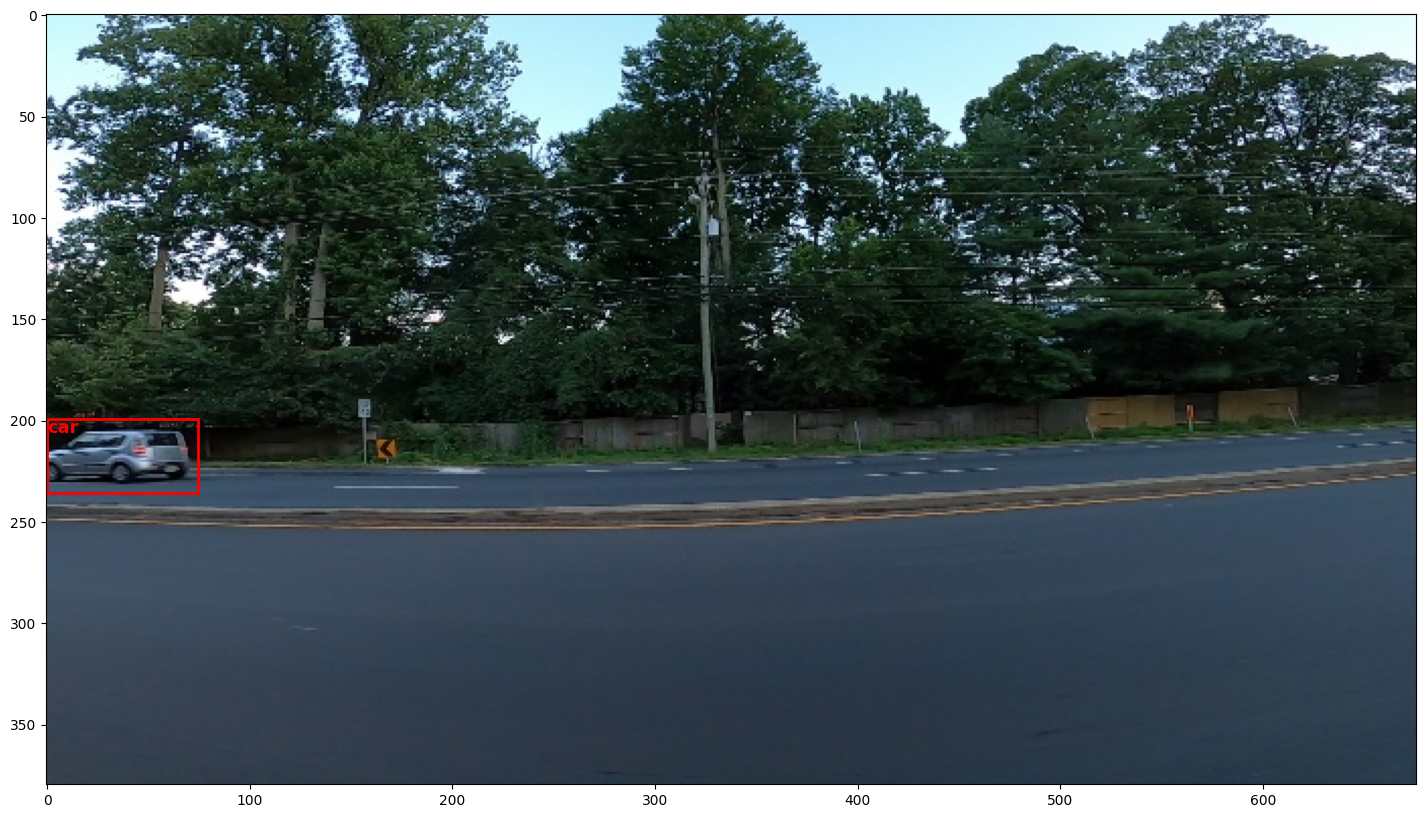

In [27]:
img, tar, _ = fcb_dataset[random.randint(0, 50)]
bbox = tar["boxes"]
fig, ax = plt.subplots(figsize=(18, 10))
ax.imshow(img)
for j in tar["labels"].tolist():
  classes = {0:"car"}
  l = classes[j]
  for i in range(len(bbox)):
    box = bbox[i]
    x, y, w, h = box[i], box[1], box[2]-box[0], box[3]-box[1]
    rect = matplotlib.patches.Rectangle((x, y), w, h, linewidth=2, edgecolor="r",
    facecolor="none",)
    ax.text(*box[:2], l, verticalalignment="top", color="red", fontsize=13, weight="bold")
    ax.add_patch(rect)
  plt.show()

In [28]:
len(df) * 10 / 100

55.9

In [29]:
image_ids = df["image"].unique()
valid_ids = image_ids[-60:]
train_ids = image_ids[:-60]
valid_df = df[df["image"].isin(valid_ids)]
train_df = df[df["image"].isin(train_ids)]
train_df.shape, valid_df.shape

((477, 7), (82, 7))

In [30]:
def collate_fn(batch):
  return tuple(zip(*batch))

In [31]:
train_dataset = Data(df, path, get_train_transform())
valid_dataset = Data(df, path, get_valid_transform())

indices = torch.randperm(len(train_dataset)).tolist()

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=6,
    collate_fn=collate_fn
)

valid_dataloader = torch.utils.data.DataLoader(valid_dataset,
                              batch_size=1,
                              shuffle=False,
                              num_workers=6,
                              collate_fn=collate_fn)

In [32]:
num_classes = 2

weights = torchvision.models.detection.FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights=weights)

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)



In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [34]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-3, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 1

In [35]:
import sys
best_epoch = 0
min_loss = sys.maxsize

for epoch in range(num_epochs):
    tk = tqdm(train_dataloader)
    model.train();
    for images, targets, image_ids in tk:
        images = list(image.to(device).permute(2, 1, 0) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        tk.set_postfix(train_loss=loss_value)
    tk.close()

    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_value}")

    #validation
    model.eval();
    with torch.no_grad():
        tk = tqdm(valid_dataloader)

        for images, targets, image_ids in tk:
            images = list(image.to(device).permute(2, 1, 0) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            val_output = model(images)
            val_output = [{k: v.to(device) for k, v in t.items()} for t in val_output]
            IOU = []
            for j in range(len(val_output)):
                a,b = val_output[j]['boxes'].cpu().detach(), targets[j]['boxes'].cpu().detach()
                chk = torchvision.ops.box_iou(a,b)
                res = np.nanmean(chk.sum(axis=1)/(chk>0).sum(axis=1))
                IOU.append(res)
            tk.set_postfix(IoU=np.mean(IOU))
        tk.close()

  0%|          | 0/355 [00:00<?, ?it/s]

Epoch #0 loss: 0.13611581818726454


  0%|          | 0/355 [00:00<?, ?it/s]

In [38]:
img,target,_ = valid_dataset[1]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device).permute(2, 1, 0)])[0]

print('predicted #boxes: ', len(prediction['boxes']))
print('real #boxes: ', len(target['boxes']))

predicted #boxes:  2
real #boxes:  1
